In [1]:
%load_ext autoreload
%autoreload 2
import pycountry
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).name.lower()
    except KeyError:
        return 'unknown'
    except AttributeError:
        return 'unknown'
    

In [3]:
city_locations_path = '../data/external/' +\
    'worldcitiespop.txt'

city_locations = pd.read_csv(city_locations_path, encoding = "ISO-8859-1").rename(columns={'City': 'city'})
city_locations = city_locations[city_locations['Population'] > 0] # filter for populated cities
city_locations['country'] = city_locations['Country'].apply(get_country_name)
print('Shape: {}'.format(city_locations.shape))
city_locations.head()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (47980, 8)


,Country,city,AccentCity,Region,Population,Latitude,Longitude,country
6,ad,andorra la vella,Andorra la Vella,7.0000,"20,430.0000",42.5000,1.5167,andorra
20,ad,canillo,Canillo,2.0000,"3,292.0000",42.5667,1.6000,andorra
32,ad,encamp,Encamp,3.0000,"11,224.0000",42.5333,1.5833,andorra
49,ad,la massana,La Massana,4.0000,"7,211.0000",42.5500,1.5167,andorra
53,ad,les escaldes,Les Escaldes,8.0000,"15,854.0000",42.5000,1.5333,andorra


In [4]:
earthquake_locations_path = '../data/external/' +\
    'earthquakes_affected_locations/earthquakes_affected_locations.csv'

earthquake_locations = pd.read_csv(earthquake_locations_path, encoding = "ISO-8859-1").drop('country', axis=1)
earthquake_locations['city'] = earthquake_locations['city'].apply(lambda c: c.lower())
print('Shape: {}'.format(earthquake_locations.shape))
earthquake_locations.head()

Shape: (2719, 12)


,id,city,latitude,longitude,geoname,year,month,day,Totaldeaths,Totalaffected,Totaldamage000US,insured_losses
0,1,takhar,36.7000,69.8000,NaN,1992,5,20,14,0,0,0
1,2,jowzan,36.7500,66.0000,Jowzjan,1994,5,1,160,100330,0,0
2,2,mazar-i-sharif,36.7500,67.0000,mazar-i-sharif,1994,5,1,160,100330,0,0
3,2,balkh,36.7501,66.8997,balkh,1994,5,1,160,100330,0,0
4,2,termez,37.2242,67.2783,NaN,1994,5,1,160,100330,0,0


In [5]:
category_cols = ['Region', 'Income group', 'Lending category']
class_path = '../data/external/' +\
    'class.csv'
world_bank_class = pd.read_csv(class_path, encoding = "ISO-8859-1", skiprows=[1])\
    .drop(['Unnamed: {}'.format(i) for i in [0,1,4]] + ['Code', 'Other'], axis=1)\
    .rename(columns={'Economy': 'country'})
    
le = LabelEncoder()
world_bank_class[category_cols] = world_bank_class[category_cols]\
    .apply(lambda c: le.fit_transform(c.astype(str)))
world_bank_class['country'] = world_bank_class['country'].apply(lambda c: str(c).lower())
world_bank_class.head()

,country,Region,Income group,Lending category
0,afghanistan,5,1,3
1,albania,1,3,2
2,algeria,3,3,2
3,american samoa,0,3,0
4,andorra,1,0,0


In [6]:
inflation_path = '../data/external/' +\
    'inflation.csv'
inflation = pd.read_csv(inflation_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 61'], axis=1).set_index('country').fillna(0)

inflation = inflation[[c for c in inflation.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
inflation = pd.melt(inflation, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'inflation'})
inflation['country'] = inflation['country'].apply(lambda c: str(c).lower())
inflation = inflation.astype({'year': 'int64', 'country': 'str'})
inflation.head()

,country,year,inflation
0,afghanistan,1993,0.0000
1,angola,1993,"1,379.4143"
2,albania,1993,85.0048
3,andorra,1993,0.0000
4,arab world,1993,9.3703


In [7]:
tot_path = '../data/external/' +\
    'terms_of_trade.csv'
terms_of_trade = pd.read_csv(tot_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 61'], axis=1).set_index('country').fillna(0)

terms_of_trade = terms_of_trade[[c for c in terms_of_trade.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
terms_of_trade = pd.melt(terms_of_trade, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'terms_of_trade'})
terms_of_trade['country'] = terms_of_trade['country'].apply(lambda c: str(c).lower())
terms_of_trade = terms_of_trade.astype({'year': 'int64', 'country': 'str'})
terms_of_trade.head()

,country,year,terms_of_trade
0,afghanistan,1993,0.0000
1,angola,1993,0.0000
2,albania,1993,0.0000
3,andorra,1993,0.0000
4,arab world,1993,0.0000


In [8]:
imports_path = '../data/external/' +\
    'imports.csv'
imports = pd.read_csv(imports_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('country').fillna(0)

imports = imports[[c for c in imports.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
imports = pd.melt(imports, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'imports'})
imports['country'] = imports['country'].apply(lambda c: str(c).lower())
imports = imports.astype({'year': 'int64', 'country': 'str'})
imports.head()

,country,year,imports
0,afghanistan,1993,0.0000
1,angola,1993,55.3903
2,albania,1993,62.2925
3,andorra,1993,0.0000
4,arab world,1993,31.9900


In [9]:
exports_path = '../data/external/' +\
    'exports.csv'
exports = pd.read_csv(exports_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('country').fillna(0)

exports = exports[[c for c in exports.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
exports = pd.melt(exports, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'exports'})
exports['country'] = exports['country'].apply(lambda c: str(c).lower())
exports = exports.astype({'year': 'int64', 'country': 'str'})
exports.head()

,country,year,exports
0,afghanistan,1993,0.0000
1,angola,1993,53.9033
2,albania,1993,15.4225
3,andorra,1993,0.0000
4,arab world,1993,28.5362


In [14]:
viv_lum_path = '../data/external/viviana_all_lum.csv'
viv_lum = pd.read_csv(viv_lum_path, delimiter=';', encoding='ISO-8859-1')
value_cols = [c for c in viv_lum.columns if c[0] == 'f' and '_' in c] 
viv_lum_cols = value_cols + ['iso_a2','country']
viv_lum = viv_lum[viv_lum['iso_a2'] != np.nan]
viv_lum['country'] = viv_lum['iso_a2'].apply(get_country_name)
viv_lum = viv_lum[viv_lum_cols].set_index(['country', 'iso_a2']).rename(columns=lambda x: x[-4:])
country_lum = pd.melt(viv_lum.reset_index().set_index('iso_a2'), id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)]).rename(columns={
    'variable': 'year',
    'value': 'country_sum_lum'
}).groupby(['country','year']).sum().reset_index().astype({'year': 'int64', 'country': 'str'}).sort_values(['year','country'])
country_lum.head()

,country,year,country_sum_lum
0,afghanistan,1993,"18,505.0000"
21,albania,1993,"30,400.0000"
42,algeria,1993,"1,459,588.0000"
63,american samoa,1993,"2,346.0000"
84,andorra,1993,"11,281.0000"


In [196]:
%run ../src/models/section_series.py
def create_panel(allow_lazy=False):
    annual_frames = []
    le = LabelEncoder()
    for year in range(1992, 2014):
        print('Loading data for year {}'.format(year))
        try:
            if allow_lazy is True:
                annual_frames.append(pd.read_csv('../data/processed/section_series_sum_small/{}.csv'.format(year)).set_index(['year','city']))
            else:
                raise FileNotFoundError()
        except FileNotFoundError:
            earthquake_locations_in_year = earthquake_locations[earthquake_locations.year == year]
            earthquake_cities_in_year = earthquake_locations_in_year['city'].unique()
            df = pd.merge(city_locations, earthquake_locations_in_year, on='city', how='left')
            df = df.fillna(0).reset_index().groupby('city').agg({
                'Totaldeaths': 'sum',
                'Totalaffected': 'sum',
                'Totaldamage000US': 'sum',
                'insured_losses': 'sum',
                'Latitude': 'first',
                'Longitude': 'first',
                'country': 'first',
                'city': 'first'
            }).set_index('city').rename(columns={
                'Latitude': 'latitude',
                'Longitude': 'longitude',
                'Totaldeaths': 'total_deaths',
                'Totalaffected': 'total_affected',
                'Totaldamage000US': 'total_damage_usd'
            }).reset_index()
            df['year'] = year
            df['earthquake_dummy'] = df.city.map(lambda c: c in earthquake_cities_in_year)
            df = df.merge(world_bank_class, on='country', how='left')
            df = df.merge(terms_of_trade, on=['year','country'], how='left')
            df = df.merge(country_lum, on=['year','country'], how='left')
            df = df.merge(inflation, on=['year','country'], how='left')
            df = df.merge(imports, on=['year','country'], how='left')
            df = df.merge(exports, on=['year','country'], how='left')
            target_coords_list = [{'lat': r[0],'lng': r[1]} for r
                in df[['latitude', 'longitude']].values]
            series_loader = SectionSeriesLoader(
                img_shape=(50, 50),
                start_year=year,
                end_year=year,
                SRC_PATH='../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/*.npz')
            df['sum_lum'] = series_loader.load_multiple_sums(target_coords_list).reshape(-1)
            df['country'] = le.fit_transform(df['country'])
            df = df.astype({'city': str}).groupby(['city','year']).first()
            df.to_csv('../data/processed/section_series_sum_small/{}.csv'.format(year))
            annual_frames.append(df)

    panel = xr.Dataset.from_dataframe(pd.concat(annual_frames))
    panel.to_dataframe().to_csv('../data/processed/section_series_sum_small/panel.csv')
    # # del annual_frames
    return panel


panel = create_panel()

Loading data for year 1992
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101992.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101992.v4b_web.stable_lights.avg_vis.tif.npz
Loading data for year 1993
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101993.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101993.v4b_web.stable_lights.avg_vis.tif.npz
Loading data for year 1994
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121994.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121994.v4b_web.stable_lights.avg_vis.tif.npz
Loading data for year 1995
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121995.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121995.v4b_web.stable

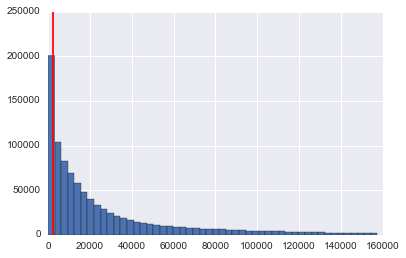

In [198]:
panel_df = panel.to_dataframe()
threshold = 50 * 50
plt.hist(panel_df.sum_lum, bins=50)
plt.axvline(threshold, c='r')
selected_cities = panel_df[panel_df['sum_lum'] > threshold].reset_index()['city'].unique()
plt.show()

In [212]:
panel.sel(city=selected_cities).to_dataframe().sort_values('earthquake_dummy', ascending=False).head(25)

,,longitude,country,latitude,total_damage_usd,total_affected,insured_losses,total_deaths,earthquake_dummy,Region,Income group,Lending category,terms_of_trade,country_sum_lum,inflation,imports,exports,sum_lum
city,year,,,,,,,,,,,,,,,,,
ferrara,2012,11.5833,90,44.8333,"15,800,000.0000","11,050.0000","128,000.0000",7.0000,True,1.0000,0.0000,0.0000,"-17,815,518,264.4807","9,545,498.0000",3.0414,27.5985,28.5864,"72,393.0000"
sivaganga,2004,78.4833,84,9.8667,"1,022,800.0000","654,512.0000","5,000.0000","16,389.0000",True,5.0000,2.0000,2.0000,"-557,648,055,487.1321","10,195,918.0000",3.7672,19.3061,17.5513,"14,462.0000"
murcia,2011,-1.1300,170,37.9870,"400,000.0000","30,600.0000","200,000.0000",20.0000,True,1.0000,0.0000,0.0000,"-11,080,732,539.6292","6,750,160.0000",3.1961,29.1670,28.9211,"94,168.0000"
mandalay,2012,96.0833,127,22.0000,"1,170.0000","1,486.0000",0.0000,38.0000,True,0.0000,2.0000,3.0000,"108,566,563,458.9410","336,228.0000",1.4676,10.8863,11.4984,"21,460.0000"
iquique,1995,-70.1431,36,-20.2208,"1,660.0000","1,833.0000",0.0000,3.0000,True,2.0000,0.0000,2.0000,"-3,572,828,934,643.4800","547,259.0000",8.2326,27.1026,29.3028,"6,576.0000"
amalias,1993,21.3500,72,37.8000,0.0000,"1,516.0000",0.0000,1.0000,True,1.0000,0.0000,0.0000,"-1,493,806,459.8767","735,097.0000",14.4145,22.9781,14.0478,"11,588.0000"
damghan,2010,54.3480,86,36.1683,0.0000,"3,600.0000",0.0000,3.0000,True,nan,nan,nan,nan,"8,987,261.0000",nan,nan,nan,"14,918.0000"
iquique,2005,-70.1431,36,-20.2208,"5,000.0000","27,645.0000","40,000.0000",11.0000,True,2.0000,0.0000,2.0000,"-1,689,991,657,745.2100","1,279,653.0000",3.0526,31.5850,38.3824,"8,134.0000"
orange,1994,149.1000,9,-33.2831,"180,000,000.0000","162,000.0000","62,400,000.0000",360.0000,True,0.0000,0.0000,0.0000,"-63,588,681,479.1652","3,306,764.0000",1.8950,18.5048,17.9722,"3,483.0000"


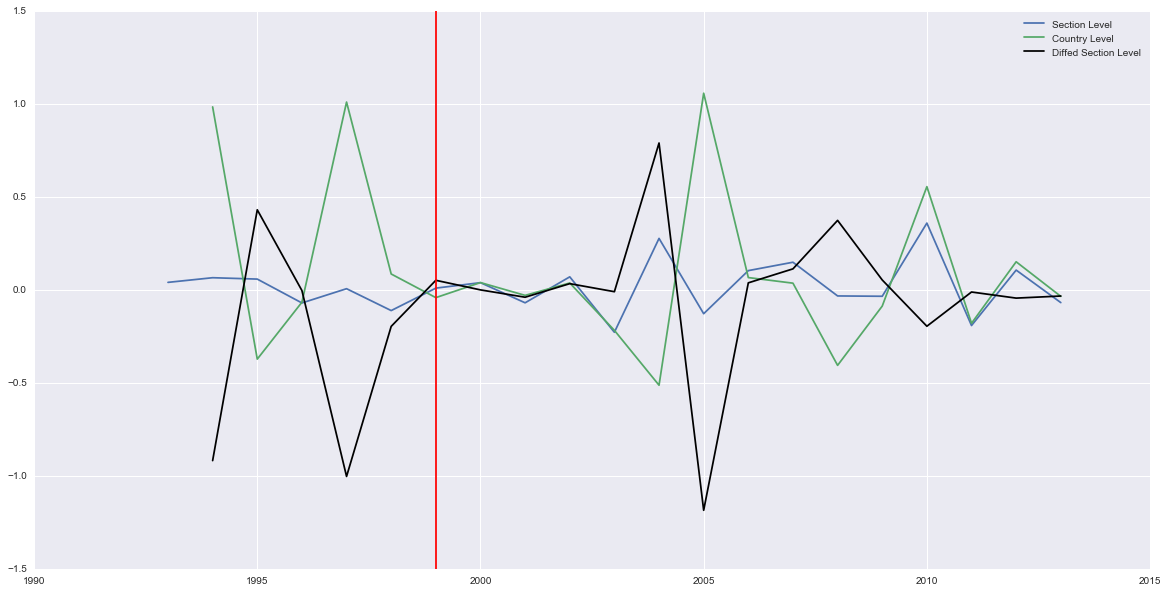

In [208]:
df = panel.sel(city='armenia').to_dataframe().fillna(0).drop(['city','latitude','longitude'],axis=1)
plt.figure(figsize=(20,10))
plt.plot(df.sum_lum.pct_change(), label='Section Level')
plt.plot(df.country_sum_lum.pct_change(), label='Country Level')
plt.plot(df.sum_lum.pct_change() - df.country_sum_lum.pct_change(), label='Diffed Section Level', c='black')
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.name, c='r')
    
plt.legend()
plt.show()

In [476]:
%%R -i port_au_prince
data <- port_au_prince
data$mean_luminosity <- log10(data$mean_luminosity*100)
data$earthquake_dummy <- as.numeric(data$earthquake_dummy)
lm(mean_luminosity ~ ., data)
data

     total_deaths total_affected insured_losses country total_damage_usd Region
1992            0              0          0e+00      80            0e+00      2
1993            0              0          0e+00      80            0e+00      2
1994            0              0          0e+00      80            0e+00      2
1995            0              0          0e+00      80            0e+00      2
1996            0              0          0e+00      80            0e+00      2
1997            0              0          0e+00      80            0e+00      2
1998            0              0          0e+00      80            0e+00      2
1999            0              0          0e+00      80            0e+00      2
2000            0              0          0e+00      80            0e+00      2
2001            0              0          0e+00      80            0e+00      2
2002            0              0          0e+00      80            0e+00      2
2003            0              0        

In [472]:
%%R -i port_au_prince
data <- port_au_prince
data$mean_luminosity <- log10(data$mean_luminosity)
require('dynlm')
# print(data)
data <- data.matrix(data)
dfm <- dynlm(data ~ L(data, 1) + L(data, 2), start=c(1995, 1), end=c(2013, 2))
print(dfm)


Error in terms.formula(formula) : '.' in formula and no 'data' argument


/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in terms.formula(formula) : '.' in formula and no 'data' argument

  warnings.warn(x, RRuntimeWarning)


In [37]:
pred = linear_tree_booster.predict(test_data)
test_ae = test_data.get_label() - pred
test_wae = (test_data.get_label() - pred) * test_data.get_label()
test_mse = mean_squared_error(test_data.get_label(), pred)
true_mean = test_data.get_label().mean()